In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from datasets import concatenate_datasets, load_dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer
from sklearn.pipeline import Pipeline
import numpy as np
import random
import pickle

In [2]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("En_De_Fr_Py_Tokenizer")
tokenizer.pad_token = tokenizer.eos_token

In [3]:
class InputIDsToString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert list of ids to NumPy array for efficient processing
        return [' '.join(np.array(input_ids)[np.isin(input_ids, [1, 2], invert=True)].astype(str)) for input_ids in X]

In [ ]:
%%time
load_sample=False
drop_language_feature = False

max_position_embeddings = 1024
code2lang = {0:'en', 1:'fr', 2:'de', 3:'py'}
lang2code = {v:k for k,v in code2lang.items()}


load_sample_prefix = '' if not load_sample else '_sample'
with open(f'tokenized_datasets/tokenized_train_datasets_1kContext_sep4lang{load_sample_prefix}.pkl', 'rb') as file:
    shuffle_seed = random.randint(1,999999)
    np.random.seed(shuffle_seed)
    tokenized_train_datasets = pickle.load(file)
    # Shuffle
    tokenized_train_datasets = {key: dataset.shuffle() for key, dataset in tokenized_train_datasets.items()}
    if drop_language_feature:
        tokenized_train_datasets = {key: dataset.remove_columns('language') for key, dataset in tokenized_train_datasets.items()}


In [ ]:
%%time
# Concatenate all datasets into one
all_datasets = concatenate_datasets([tokenized_train_datasets[i] for i in range(4)])

# Extract input_ids and convert them to strings as they are token indices
input_ids = all_datasets['input_ids']
languages = all_datasets['language']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, languages, test_size=0.2, random_state=42)


In [4]:
load_sample=False
drop_language_feature = False

max_position_embeddings = 1024
code2lang = {0:'en', 1:'fr', 2:'de', 3:'py'}
lang2code = {v:k for k,v in code2lang.items()}

load_sample_prefix = '' if not load_sample else '_sample'
# Load the tokenized validation datasets
with open(f'tokenized_datasets/tokenized_valid_datasets_1kContext_sep4lang{load_sample_prefix}.pkl', 'rb') as file:
    tokenized_valid_datasets = pickle.load(file)
    tokenized_valid_datasets = {key: dataset.shuffle() for key, dataset in tokenized_valid_datasets.items()}
    if drop_language_feature:
        tokenized_valid_datasets = {key: dataset.remove_columns('language') for key, dataset in tokenized_valid_datasets.items()}

In [ ]:
%%time
# Concatenate all datasets into one
eval_all_datasets = concatenate_datasets([tokenized_valid_datasets[i] for i in range(4)])

# Extract input_ids and convert them to strings as they are token indices
eval_input_ids = eval_all_datasets['input_ids']
eval_languages = eval_all_datasets['language']

In [8]:
# Create the pipeline components
tfidf_vectorizer = TfidfVectorizer()
classifier = LogisticRegression(loss='modified_huber', random_state=42)

# Set up the pipeline
pipeline = Pipeline([
    ('input_to_string', InputIDsToString()),
    ('tfidf', tfidf_vectorizer),
    ('clf', classifier)
])

In [ ]:
# Train the pipeline
pipeline.fit(X_train, y_train)

In [10]:
import pickle

# Save the pipeline
with open('language_router_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [ ]:
# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


## Evaluate on validation set

In [ ]:
%%time
# Use the classifier to predict the languages
eval_y_pred = pipeline.predict(eval_input_ids)

# Compute metrics
accuracy = accuracy_score(eval_languages, eval_y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(eval_languages, eval_y_pred, average='weighted')
conf_matrix = confusion_matrix(eval_languages, eval_y_pred)

# Print results
print(f"Evaluation on validation dataset Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix using seaborn's heatmap functionality. Normalizes the matrix and annotates cells with the normalized values.
    :param cm: Confusion matrix array
    :param class_names: List of class names for the axes
    :param title: Title for the graph
    :param cmap: Color map of the heatmap
    """
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_names = ['English', 'French', 'German', 'Python']
    plt.figure(figsize=(10, 8))
    print(class_names)
    sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap=cmap, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
    plt.title(title)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.savefig('Router_confMat.pdf', format='pdf', dpi=300)
    plt.show()


['English', 'French', 'German', 'Python']


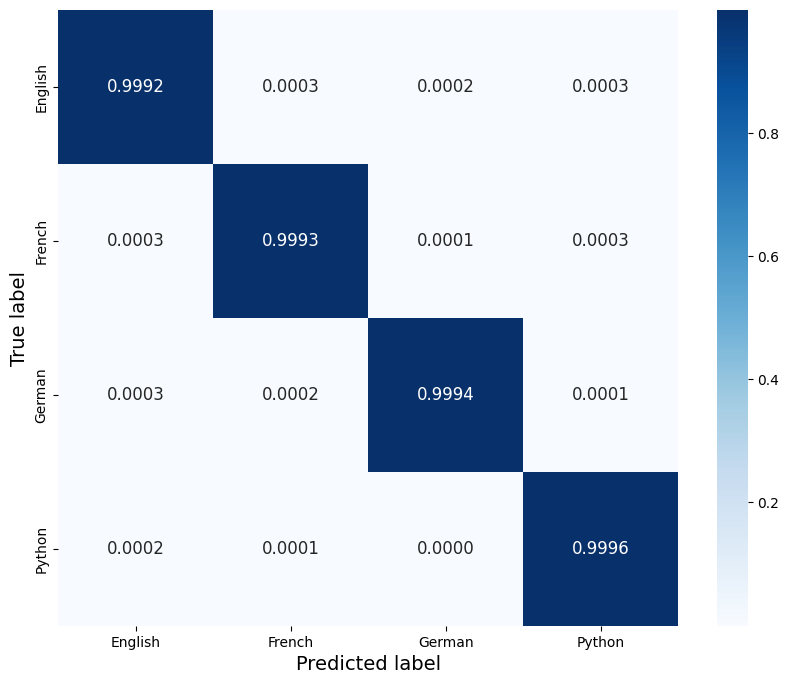

In [46]:
# Assuming conf_matrix is already computed as shown previously
# code2lang2 = {0: 'English', 1: 'French', 2: 'German', 3: 'Python'}
class_names = [lang for lang, code in sorted(lang2code.items(), key=lambda item: item[1])]

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names, title='')


In [16]:
# Extract the components from the pipeline
tfidf_vectorizer = pipeline.named_steps['tfidf']
classifier = pipeline.named_steps['clf']

# Get the feature names (these are the token IDs as strings)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients from the classifier
if hasattr(classifier, 'coef_'):
    coef = classifier.coef_
elif hasattr(classifier, 'feature_importances_'):
    coef = classifier.feature_importances_

# Get the class labels
class_labels = classifier.classes_

In [ ]:
# Decode the top 10 features per class
top_features_per_class = {}
code2lang = {0: 'English', 1: 'French', 2: 'German', 3: 'Python'}
for class_index, class_label in enumerate(class_labels):
    if len(class_labels) > 1:  # For multi-class classifiers
        top_feature_indices = np.argsort(coef[class_index])[-20:]
    else:  # For binary classifiers
        top_feature_indices = np.argsort(coef)[-20:]
    
    top_features = [feature_names[i] for i in top_feature_indices]
    top_features_decoded = [tokenizer.decode([int(token_id)]) for token_id in top_features]
    
    top_features_per_class[class_label] = top_features_decoded

# Display the top features per class
for class_label, top_features in top_features_per_class.items():
    print(f"Top 10 features for class {code2lang[class_label]}:")
    for feature in top_features:
        print(feature)
    print("\n")